In [1]:
import torch

In [2]:
# define a loss
def mse_loss(x, y):
    return (x-y)**2

# update some guessed value according to the gradient descent of the loss function
def update_params(x, y):
    L = mse_loss(x, y)
    dLd_x = torch.autograd.grad(L, inputs=[x]) # the inputs mean dL/d(x) will be computed (a tuple will be returned for all the gradients)
    x = x - 0.01*dLd_x[0]
    return x

In [3]:
# testing
x_guess, y_actual = -0.5, -1.0
x = torch.tensor(x_guess, requires_grad=True)
y = torch.tensor(y_actual, requires_grad=True)

for i in range(10):
    x = update_params(x, y)
    print(f'the x value at iteration {i} is {x:.3f}, error between guess and actual: {mse_loss(x, y):.3f}')

the x value at iteration 0 is -0.510, error between guess and actual: 0.240
the x value at iteration 1 is -0.520, error between guess and actual: 0.231
the x value at iteration 2 is -0.529, error between guess and actual: 0.221
the x value at iteration 3 is -0.539, error between guess and actual: 0.213
the x value at iteration 4 is -0.548, error between guess and actual: 0.204
the x value at iteration 5 is -0.557, error between guess and actual: 0.196
the x value at iteration 6 is -0.566, error between guess and actual: 0.188
the x value at iteration 7 is -0.575, error between guess and actual: 0.181
the x value at iteration 8 is -0.583, error between guess and actual: 0.174
the x value at iteration 9 is -0.591, error between guess and actual: 0.167


In [4]:
# now; doing it over a different loss; trying the rose method

In [5]:
def bijective_tanh(x:torch.Tensor)->torch.Tensor:
    return torch.tanh(x)

def inverse_tanh(x:torch.Tensor)->torch.Tensor:
    return torch.atanh(x)

def GLn(n:int) -> torch.Tensor:
    """Generate a GLn group element of size n and its inverse.

    Args:
        n: The element group size.

    Returns:
        A, A_inv: A GL(n) element and it's inverse, realised in R^n.
    """

    while(1):
        A = torch.rand(n,n, requires_grad=True)
        try:
            return A, torch.linalg.pinv(A)
        except:
            continue


def GLn_action(mat2, act1, act1_inv, mat1, x, x_inv, g, g_inv):
    """Perform a loss-invariant group (GLn) action via mat2 and mat1.

    Args:
        mat2: a x b matrix.
        act1: a bijective activation function.
        act1_inv: the inverse function of act1.
        mat1: b x c matrix.
        x: the input matrix of shape c x c.
        x_inv: the inverse of x.
        g: the GLn group element
        g_inv: the inverse of g
    
    Returns:
        New weight matrices mat2_star, mat1_star that are 
        group actions of the input weight matrices.
    """
    mat2_star = torch.einsum('ij,jk->ik', [mat2, g_inv])
    prev_layer = act1(torch.einsum('ij,jk->ik', [mat1, x]))
    mat1_star_times_input = act1_inv(torch.einsum('ij,jk->ik', [g, prev_layer]))
    mat1_star = torch.einsum('ij,jk->ik', [mat1_star_times_input, x_inv])
    
    return mat2_star, mat1_star

In [6]:
# let's do MSE loss to try and update the above, further outputting the actual dL/dweights values
def mse_loss_MLP(y_pred, y):
    return torch.sum((y_pred-y)**2)

# update some guessed value according to the gradient descent of the loss function
def update_params_MLP(y_pred, y, mat2, mat1):
    L = mse_loss_MLP(y_pred, y)
    dLd_weights = torch.autograd.grad(L, inputs=[mat2, mat1]) # https://stackoverflow.com/questions/54754153/autograd-grad-for-tensor-in-pytorch
    mat2 = mat2 - 0.01*dLd_weights[0]
    mat1 = mat1 - 0.01*dLd_weights[1]
    return mat2, mat1

In [7]:
print('doing torch autograd gd over 100 epochs on a 2 layer subnet, separated by a bijective activation, as per rose standards.')
print('pre-activations are square and need to be (unchecked) invertible')

# X, y_pred (=M2@act1@M1@X), y_actual

# say we have a layer with dimensions going from 5 -> 3 -> 1.
X = torch.rand(5, 5)
mat1 = torch.rand(3, 5, requires_grad=True)
mat2 = torch.rand(1, 3, requires_grad=True)

# at the moment, the output of this sample function is:
y_pred = mat2@bijective_tanh(mat1@X)
y_actual = torch.tensor([[1.45, 0.8, 1.6, 1.6, 1.5]])
print(f'  y_pred: {y_pred}, \n  y_actual: {y_actual}')

for i in range(1000):
    mat2, mat1 = update_params_MLP(y_pred, y_actual, mat2, mat1)
    y_pred = mat2@bijective_tanh(mat1@X)

    if i%200 == 199:
        print(f'\terror between guess and actual after epoch {i}: {mse_loss_MLP(y_pred, y_actual):.3f}')

print(f'  y_pred: {y_pred}, \n  y_actual: {y_actual}')

doing torch autograd gd over 100 epochs on a 2 layer subnet, separated by a bijective activation, as per rose standards.
pre-activations are square and need to be (unchecked) invertible
  y_pred: tensor([[0.4515, 0.6178, 0.5113, 0.4921, 0.6145]], grad_fn=<MmBackward0>), 
  y_actual: tensor([[1.4500, 0.8000, 1.6000, 1.6000, 1.5000]])
	error between guess and actual after epoch 199: 0.587
	error between guess and actual after epoch 399: 0.484
	error between guess and actual after epoch 599: 0.139
	error between guess and actual after epoch 799: 0.045
	error between guess and actual after epoch 999: 0.021
  y_pred: tensor([[1.4386, 0.8179, 1.4943, 1.5801, 1.5967]], grad_fn=<MmBackward0>), 
  y_actual: tensor([[1.4500, 0.8000, 1.6000, 1.6000, 1.5000]])


In [8]:
# with teleportations... now
# a second loss thing will be needed; specifically we should need to maximise the norm of the loss

In [9]:
# let's do MSE loss to try and update the above, further outputting the actual dL/dweights values
def mse_loss_MLP(y_pred, y):
    return torch.sum((y_pred-y)**2)

# update some guessed value according to the gradient descent of the loss function
def update_params_MLP_teleport(y_pred, y, mat2, mat1, X):
    # can use g=id. as the standard (perf. ck)
    # recompute y_pred.

    # generate an initial teleport step
    g = torch.eye(mat2.shape[-1], requires_grad=True) # already in GL(n); question is, will invertibility be invariant to ga?
    g_inv = torch.linalg.pinv(g)
    n = 100

    for i in range(n): # number of g steps runs to compute
        mat2_star, mat1_star = GLn_action(mat2, bijective_tanh, inverse_tanh, mat1, X, torch.linalg.pinv(X), g, g_inv)
        if i == 1 or i == n-1:
            print(f'Loss at start: {L}, dLdt = {dLdt}')

        y_pred_new = mat2_star@bijective_tanh(mat1_star@X)
        L = mse_loss_MLP(y_pred_new, y) # this should remain unchanged through the teleport step; and it does!
        dLd_weights = torch.autograd.grad(L, inputs=[mat2, mat1], create_graph=True) # dL/dmat2, dL/dmat1

        # then compute the norm on the whole shebang for grad. ascent
        dLdt = torch.norm(dLd_weights[0])**2 + torch.norm(dLd_weights[1])**2
        dLdt_dg = torch.autograd.grad(dLdt, inputs=[g])
        g = g + 0.1*dLdt_dg[0] # improve on g such that the norm increases
        g_inv = torch.linalg.pinv(g)
    
    print('loss at end: ', L)
    mat2_star, mat1_star = GLn_action(mat2, bijective_tanh, inverse_tanh, mat1, X, torch.linalg.pinv(X), g, g_inv)
    return mat2_star, mat1_star

In [14]:
print('doing torch autograd gd (com teleport) over 100 epochs on a 2 layer subnet, separated by a bijective activation, as per rose standards.')
print('pre-activations are square and need to be (unchecked) invertible')

# X, y_pred (=M2@act1@M1@X), y_actual

# say we have a layer with dimensions going from 5 -> 3 -> 1.
X = torch.rand(5, 5)
mat1 = torch.rand(3, 5, requires_grad=True)
mat2 = torch.rand(1, 3, requires_grad=True)

# at the moment, the output of this sample function is:
y_pred = mat2@bijective_tanh(mat1@X)
y_actual = torch.tensor([[1.45, 0.8, 1.6, 1.6, 1.5]])
print(f'  y_pred: {y_pred}, \n  y_actual: {y_actual}')

losses = []
teleport_schedule = [1, 2, 3, 4, 5]
for i in range(100):
    if i in teleport_schedule: # only teleport at acceptable times
        mat2, mat1 = update_params_MLP_teleport(y_pred, y_actual, mat2, mat1, X)
        y_pred = mat2@bijective_tanh(mat1@X)

    mat2, mat1 = update_params_MLP(y_pred, y_actual, mat2, mat1)
    y_pred = mat2@bijective_tanh(mat1@X)
    losses.append(mse_loss_MLP(y_pred, y_actual))

    print(f'\terror between guess and actual after epoch {i}: {losses[-1]:.3f}')

print(f'  y_pred: {y_pred}, \n  y_actual: {y_actual}')

doing torch autograd gd (com teleport) over 100 epochs on a 2 layer subnet, separated by a bijective activation, as per rose standards.
pre-activations are square and need to be (unchecked) invertible
  y_pred: tensor([[1.1588, 0.9245, 1.0141, 1.1477, 0.9601]], grad_fn=<MmBackward0>), 
  y_actual: tensor([[1.4500, 0.8000, 1.6000, 1.6000, 1.5000]])
	error between guess and actual after epoch 0: 0.713
Loss at start: 0.7125652432441711, dLdt = 16.52691078186035
Loss at start: 0.7125644683837891, dLdt = 16.526893615722656
loss at end:  tensor(0.7126, grad_fn=<SumBackward0>)
	error between guess and actual after epoch 1: 0.563
Loss at start: 0.5628767609596252, dLdt = 10.871391296386719
Loss at start: 0.5628764033317566, dLdt = 10.871380805969238
loss at end:  tensor(0.5629, grad_fn=<SumBackward0>)
	error between guess and actual after epoch 2: 0.464
Loss at start: 0.46445783972740173, dLdt = 7.146270275115967
Loss at start: 0.46445778012275696, dLdt = 7.146267890930176
loss at end:  tensor

teleported at [1, 2, 3, 4, 5]


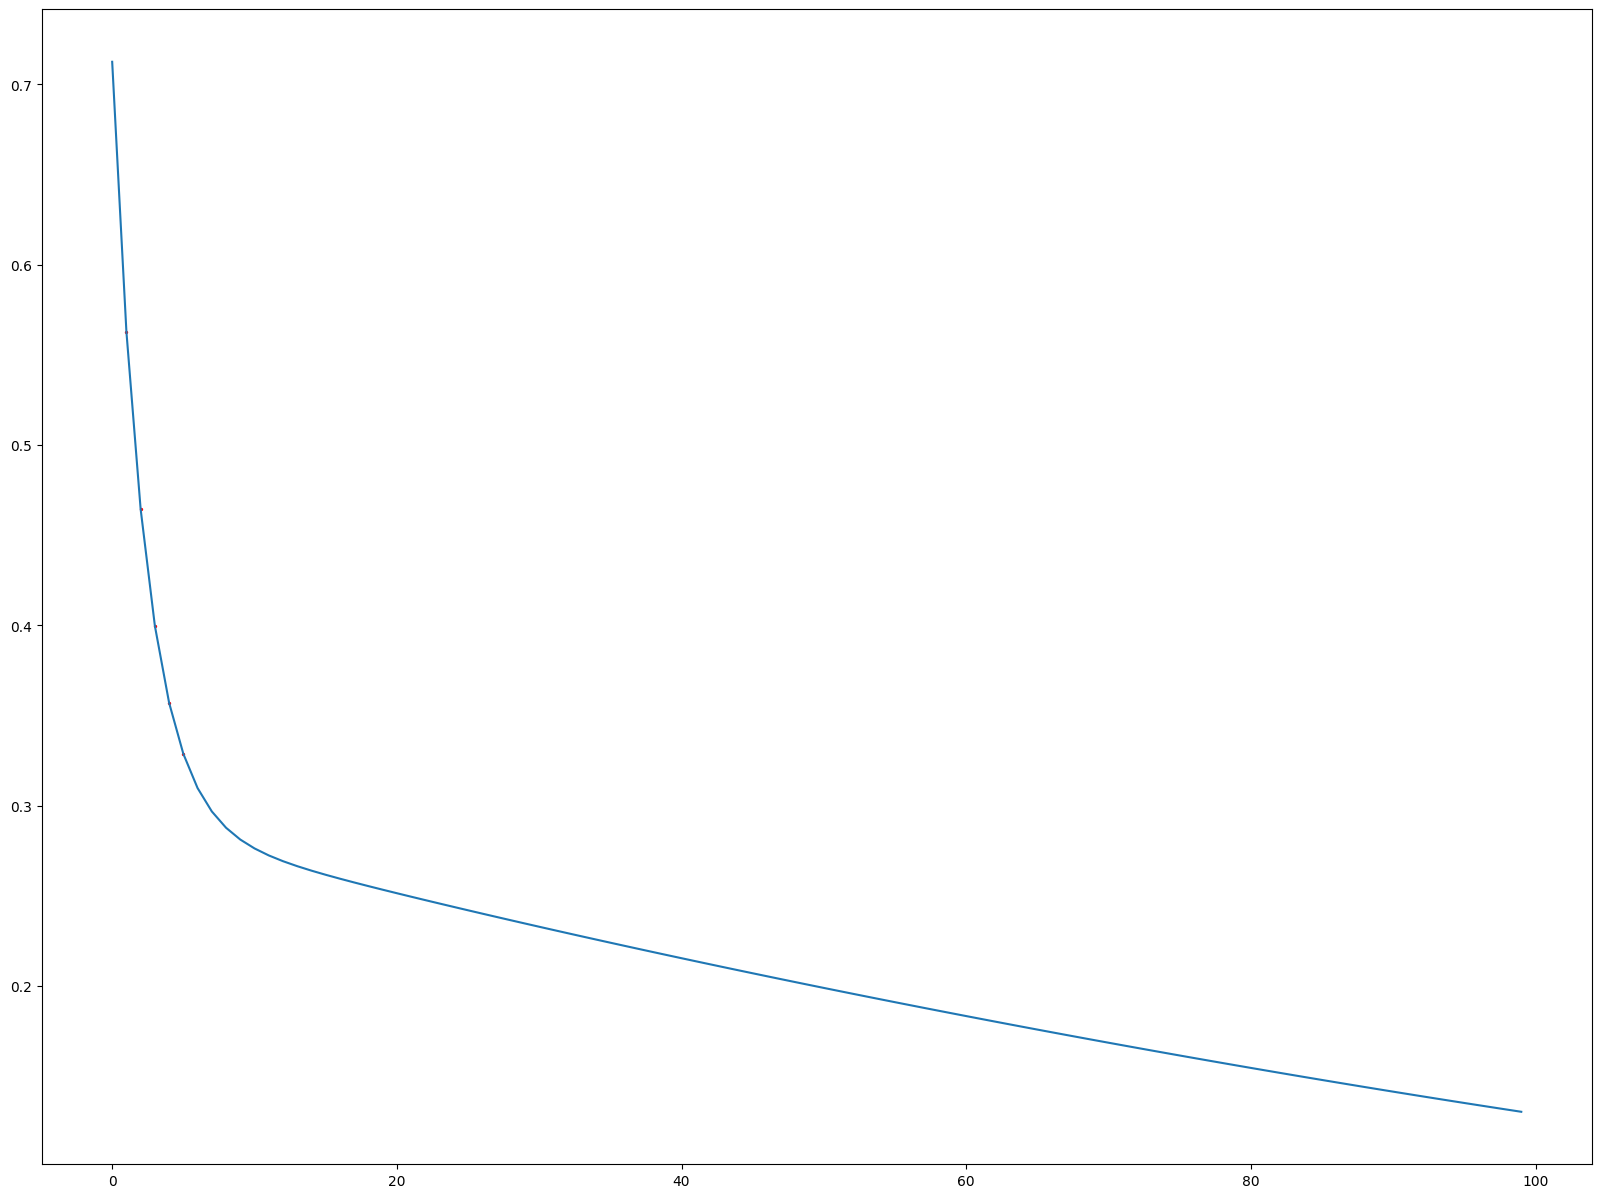

In [16]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 15))
losses = [losses[i].detach().numpy() for i in range(len(losses))]
plt.plot(losses);
plt.scatter(teleport_schedule, np.take(losses, teleport_schedule), s=2, c='red')
print(f'teleported at {teleport_schedule}')